In [5]:
suppressMessages(library(dplyr))
suppressMessages(library(reshape2))
suppressMessages(library(ggplot2))
library(tidyr, warn.conflicts = FALSE)
options(dplyr.summarise.inform = FALSE)# Suppress summarise info
library(UpSetR)
library(ggupset)
library(PaletteWoodsHole)
library(cowplot)

In [6]:
df <- read.table(
        file = "~/2020-osmolytes/genome-searching/predict_synthesis/2021-03-predicted-bacterial-osmolyte-synthesis.tsv", 
                 sep = '\t', header = F)
dim(df)
# only keep metabs that have transporters
osmo <- c('Glycerol','Glycine betaine','Sorbitol','Mannitol','Taurine')
df <- df[, c(1,which(df[1,] %in% osmo))]
# create df for just names of metab and trans,break,syn
fn <- df[1:2,-1]
# create p/a table
pa <- df[3:dim(df)[1],]
tmp <- pa$V1; pa$V1 <- NULL
pa <- as.data.frame(sapply(pa, as.numeric))
rownames(pa) <- tmp
# create taxa table
marref <- read.delim("~/2020-osmolytes/genome-searching/MarRef_DBs/MarRef_v5.txt")
dim(marref)
# removing the marref with NA's in accession value
idx <- which(is.na(marref$assembly_accession_refseq))
marref <- marref[-idx,]
# replace rownames with accession value
rownames(marref) <- marref$assembly_accession_refseq
# rearrange so that rownames are equal to the synthesis tsv file
marref <- marref[rownames(pa),]

# finally split up p/a table by transp, break, syn
t <- which(fn[2,] == "TRANSPORT")
tr <- pa[,t]; colnames(tr) <- fn[1,t]
b <- which(fn[2,] == "BREAKDOWN")
br <- pa[,b]; colnames(br) <- fn[1,b]
s <- which(fn[2,] == "SYNTHESIS")
syn <- pa[,s]; colnames(syn) <- fn[1,s]

# check dim
dim(syn)[1] == dim(pa)[1]
dim(syn)[2] == dim(tr)[2]
dim(br)[2] == dim(tr)[2]

# check names
all(rownames(br) == marref$assembly_accession_refseq)

# add rownames back
rownames(tr) <- rownames(pa)
rownames(br) <- rownames(pa)
rownames(syn) <- rownames(pa)

[1] 899  49

[1] 970 126

[1] TRUE

[1] TRUE

[1] TRUE

[1] TRUE

In [7]:
length(which(apply(tr, 1, function(x) sum(x))>0))/dim(tr)[1]
length(which(apply(tr, 1, function(x) sum(x))>0))
apply(tr, 2, function(x) sum(x))


[1] 0.522854

[1] 469

Glycerol Glycine betaine        Mannitol        Sorbitol         Taurine 
            139             427             143             143              53

In [8]:
## Adding a custom classification 
marref$custom <- marref$phylum
idx <- marref$custom == "Proteobacteria" # Split proteobacteria into delta, alpha, beta, gamma, epsilon, zeta, oligoflex
marref$custom[idx] <- marref$class[idx]

idx <- marref$kingdom == "Archaea" # combine Eury and Crenarchaeota
marref$custom[idx] <- "Archaea"

idx <- marref$custom == "Actinobacteria (Phylum)" # drop the extra label for Actinos
marref$custom[idx] <- "Actinobacteria"

unique(marref$custom)
## Create color palette for taxa
tax_color <- sunset_winter
names(tax_color) <- c("Actinobacteria", "Alphaproteobacteria","Firmicutes","Gammaproteobacteria","Other","Cyanobacteria")

[1] "Deltaproteobacteria"            "Alphaproteobacteria"           
 [3] "Betaproteobacteria"             "Cyanobacteria"                 
 [5] "Gammaproteobacteria"            "Bacteroidetes"                 
 [7] "Archaea"                        "Actinobacteria"                
 [9] "Firmicutes"                     "Thermotogae (Phylum)"          
[11] "Aquificae"                      "Calditrichaeota"               
[13] "Chlorobi"                       "Epsilonproteobacteria"         
[15] "Deferribacteres (Phylum)"       "Unclassified"                  
[17] "Planctomycetes"                 "Verrucomicrobia"               
[19] "Tenericutes"                    "Chloroflexi"                   
[21] "Spirochaetes"                   "Zetaproteobacteria"            
[23] "Deinococcus-Thermus"            "Thermodesulfobacteria (Phylum)"
[25] "Aquificae (Phylum)"             "Synergistetes"                 
[27] "Oligoflexia"                    "Fusobacteria"

Using class as id variables



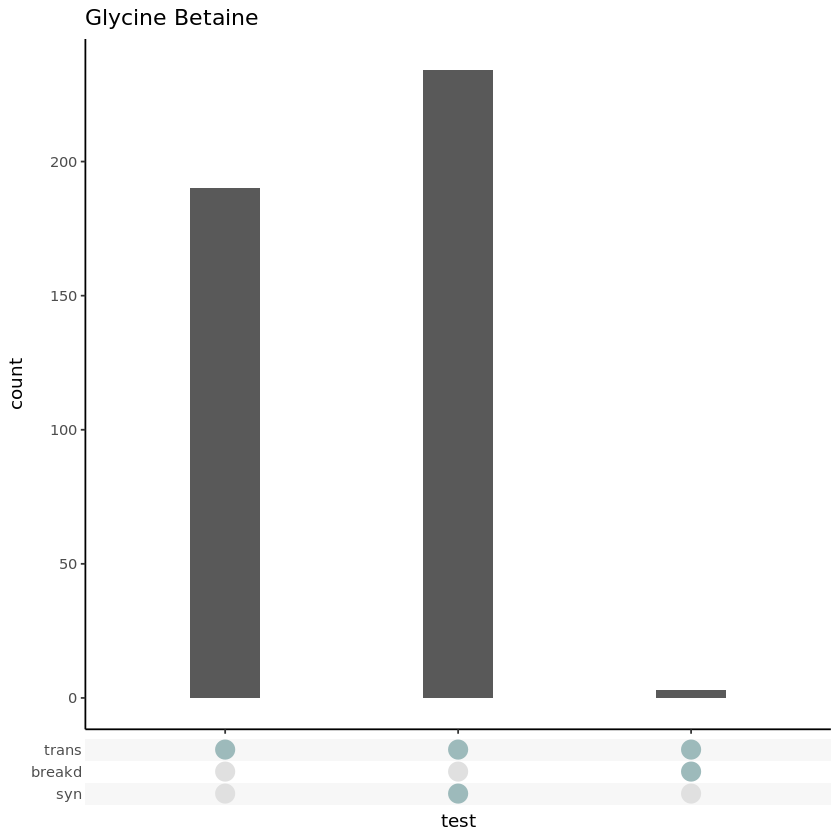

In [9]:
gcb <- data.frame(class = marref$custom, trans=tr$`Glycine betaine`, syn=syn$`Glycine betaine`, breakd=br$`Glycine betaine`)
rownames(gcb) <- rownames(pa)
a <- gcb %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    melt() %>%
    mutate(variable = factor(variable, levels = c("transonly","transsyn","transbreakd","all"))) %>%
    filter(value > 0) %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity",width = 0.5)+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = tax_color)+
        theme_bw()+
        ggtitle("Glycine Betaine")+
        xlab("n")

b <- gcb %>%
    filter(trans == 1) %>%
    select(-class) %>%
    as_tibble(rownames = "accession") %>%
    gather(path, value, -accession) %>%
    filter(value == 1) %>%
    group_by(accession) %>%
    summarise(test = list(path)) %>%
      ggplot(aes(x = test)) +
        geom_bar(width = 0.3)+theme_classic()+
        scale_x_upset(order_by = "degree", sets = c("trans","breakd","syn"))+
        theme_combmatrix(combmatrix.panel.point.color.fill = atlantis[1], 
                         combmatrix.panel.point.size = 5,
                        combmatrix.panel.line.size = 0)+
        ggtitle("Glycine Betaine")
#cairo_pdf(file = "gcb.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(b, ncol=1, align="v", axis = "lrtb")
#dev.off()

In [10]:
a<-gcb %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) # transporter + synthesis + breakdown
colSums(a[,2:8])

trans         syn      breakd   transonly    transsyn transbreakd 
        427         234           3         190         234           3 
        all 
          0

Using class as id variables



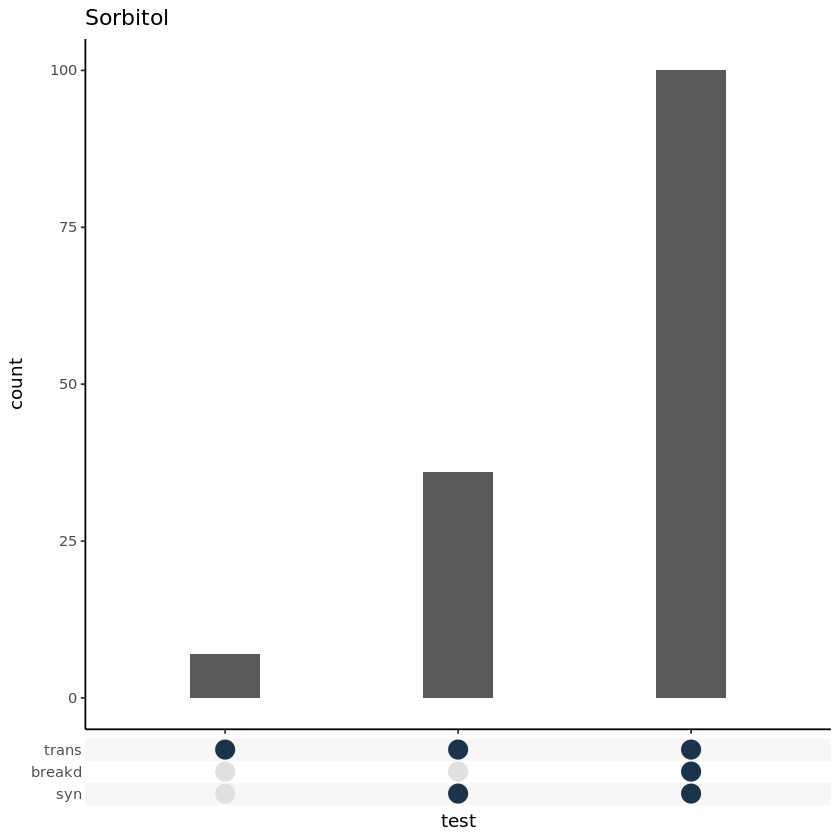

In [11]:
sorb <- data.frame(class = marref$custom, trans=tr$Sorbitol, syn=syn$Sorbitol, breakd=br$Sorbitol)
rownames(sorb) <- rownames(pa)
a <- sorb %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    melt() %>%
    mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    filter(value > 0) %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity",width = 0.5)+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = tax_color)+
        theme_bw()+
        ggtitle("Sorbitol")+
        xlab("n")

b <- sorb %>%
    filter(trans == 1) %>%
    select(-class) %>%
    as_tibble(rownames = "accession") %>%
    gather(path, value, -accession) %>%
    filter(value == 1) %>%
    group_by(accession) %>%
    summarise(test = list(path)) %>%
      ggplot(aes(x = test)) +
        geom_bar(width = 0.3)+theme_classic()+
        scale_x_upset(order_by = "degree", sets = c("trans","breakd","syn"))+
        theme_combmatrix(combmatrix.panel.point.color.fill = atlantis[2], 
                         combmatrix.panel.point.size = 5,
                        combmatrix.panel.line.size = 0)+
        ggtitle("Sorbitol")
#cairo_pdf(file = "sorb.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(b, ncol=1, align="v", axis = "lrtb")
#dev.off()

Using class as id variables



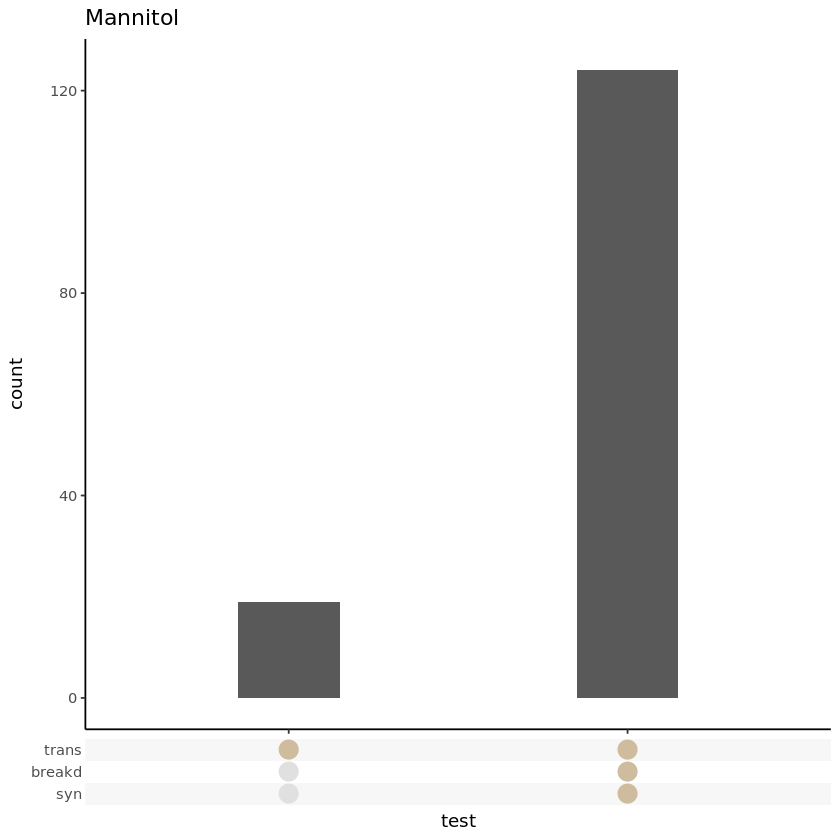

In [12]:
mann <- data.frame(class = marref$custom, trans=tr$Mannitol, syn=syn$Mannitol, breakd=br$Mannitol)
rownames(mann) <- rownames(pa)
a <- mann %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    melt() %>%
    mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    filter(value > 0) %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity",width = 0.5)+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = tax_color)+
        theme_bw()+
        ggtitle("Mannitol")+
        xlab("n")

b <- mann %>%
    filter(trans == 1) %>%
    select(-class) %>%
    as_tibble(rownames = "accession") %>%
    gather(path, value, -accession) %>%
    filter(value == 1) %>%
    group_by(accession) %>%
    summarise(test = list(path)) %>%
      ggplot(aes(x = test)) +
        geom_bar(width = 0.3)+theme_classic()+
        scale_x_upset(order_by = "degree", sets = c("trans","breakd","syn"))+
        theme_combmatrix(combmatrix.panel.point.color.fill = atlantis[3], 
                         combmatrix.panel.point.size = 5,
                        combmatrix.panel.line.size = 0)+
        ggtitle("Mannitol")
#cairo_pdf(file = "mann.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(b, ncol=1, align="v", axis = "lrtb")
#dev.off()

Using class as id variables



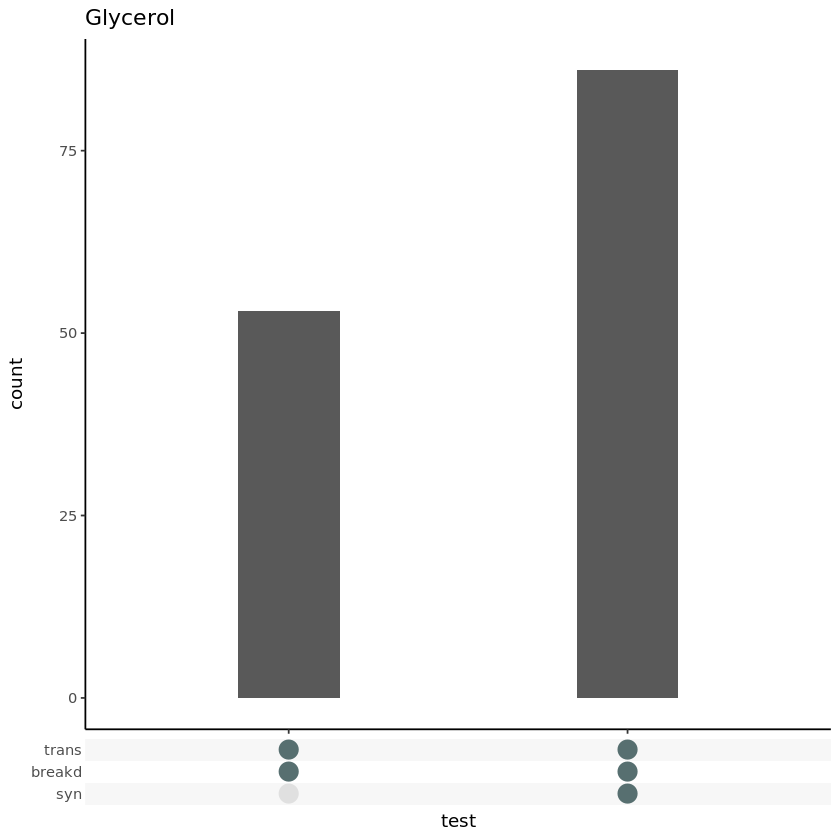

In [13]:
glyc <- data.frame(class = marref$custom, trans=tr$Glycerol, syn=syn$Glycerol, breakd=br$Glycerol)
rownames(glyc) <- rownames(pa)
a <- glyc %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    melt() %>%
    mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    filter(value > 0) %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity",width = 0.5)+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = tax_color)+
        theme_bw()+
        ggtitle("Glycerol")+
        xlab("n")

b <- glyc %>%
    filter(trans == 1) %>%
    select(-class) %>%
    as_tibble(rownames = "accession") %>%
    gather(path, value, -accession) %>%
    filter(value == 1) %>%
    group_by(accession) %>%
    summarise(test = list(path)) %>%
      ggplot(aes(x = test)) +
        geom_bar(width = 0.3)+theme_classic()+
        scale_x_upset(order_by = "degree", sets = c("trans","breakd","syn"))+
        theme_combmatrix(combmatrix.panel.point.color.fill = atlantis[4], 
                         combmatrix.panel.point.size = 5,
                        combmatrix.panel.line.size = 0)+
        ggtitle("Glycerol")
#cairo_pdf(file = "glyc.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(b, ncol=1, align="v", axis = "lrtb")
#dev.off()

Using class as id variables



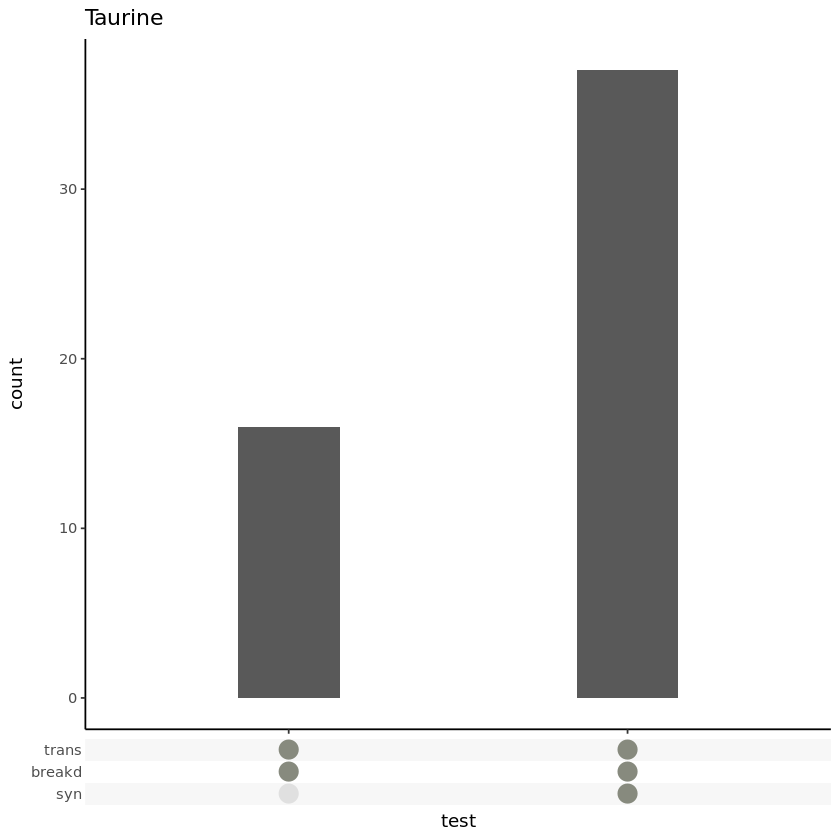

In [14]:
taur <- data.frame(class = marref$custom, trans=tr$Taurine, syn=syn$Taurine, breakd=br$Taurine)
rownames(taur) <- rownames(pa)

a<-taur %>%
    filter(trans == 1) %>%
    mutate(transonly = ifelse(syn == 0 & breakd == 0, 1, 0)) %>% # transporter only
    mutate(transsyn = ifelse(syn == 1 & breakd == 0, 1, 0)) %>% # transporter + synthesis only
    mutate(transbreakd = ifelse(syn == 0 & breakd == 1, 1, 0)) %>% # transporter + breakdown only
    mutate(all = ifelse(syn == 1 & breakd == 1, 1, 0)) %>% # transporter + synthesis + breakdown
    select(class, transonly, transsyn, transbreakd, all) %>%
    group_by(class) %>%
    summarise(transonly = sum(transonly), transsyn = sum(transsyn),transbreakd=sum(transbreakd), all=sum(all)) %>%
    mutate(n = transonly + transsyn + transbreakd + all) %>%
    mutate(n = n/sum(n)) %>%
    mutate(class = ifelse(n < 0.1, "Other", class))%>%
    select(-n) %>%
    melt() %>%
    mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    filter(value > 0) %>%
    ggplot(aes(x = variable, y = value, fill = class))+
        geom_bar(position="stack", stat="identity",width = 0.5)+
        theme(axis.text.x = element_text(angle = 45))+
        scale_fill_manual(values = tax_color)+
        theme_bw()+
        ggtitle("Taurine")+
        xlab("n")

b<-taur %>%
    filter(trans == 1) %>%
    select(-class) %>%
    as_tibble(rownames = "accession") %>%
    gather(path, value, -accession) %>%
    filter(value == 1) %>%
    group_by(accession) %>%
    summarise(test = list(path)) %>%
      ggplot(aes(x = test)) +
        geom_bar(width = 0.3)+theme_classic()+
        scale_x_upset(order_by = "degree", sets = c("trans","breakd","syn"))+
        theme_combmatrix(combmatrix.panel.point.color.fill = atlantis[9], 
                         combmatrix.panel.point.size = 5,
                        combmatrix.panel.line.size = 0)+
        ggtitle("Taurine")
#cairo_pdf(file = "taur.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(b, ncol=1, align="v", axis = "lrtb")
#dev.off()


In [15]:
all <- pa
colnames(all) <- paste0(fn[2,],".",fn[1,])

a <- all %>%
mutate(transonly = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 0 & `SYNTHESIS.Glycine betaine` == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 1 & `SYNTHESIS.Glycine betaine` == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 0 & `SYNTHESIS.Glycine betaine` == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 1 & `SYNTHESIS.Glycine betaine` == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) %>%
melt() %>%
mutate(compound = "glycine betaine", `.before` = class) %>%
mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
    ggplot(aes(x = variable, y = class, size = value, color = compound))+geom_point()+
        scale_color_manual(values = jason[1])+coord_fixed(ratio = 2)+
        theme_minimal()+
        theme(legend.position = "none")+
        theme(axis.title.y=element_blank(),axis.text.y=element_blank())+
        theme(axis.title.x=element_blank(),axis.text.x = element_text(angle = 90))+
        scale_size(limits = c(1, 125),range=c(0,15), breaks = c(5,25,75,125))+
        theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))+
        ggtitle("glycine betaine")


b <- all %>%
mutate(transonly = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 0 & SYNTHESIS.Sorbitol == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 1 & SYNTHESIS.Sorbitol == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 0 & SYNTHESIS.Sorbitol == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 1 & SYNTHESIS.Sorbitol == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) %>%
melt() %>%
mutate(compound = "sorbitol", `.before` = class) %>%
mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
    ggplot(aes(x = variable, y = class, size = value, color = compound))+geom_point()+
        scale_color_manual(values = jason[2])+coord_fixed(ratio = 2)+
        theme_minimal()+
        theme(axis.title.y=element_blank(),axis.text.y=element_blank())+
        theme(axis.title.x=element_blank(),axis.text.x = element_text(angle = 90))+
        theme(legend.position = "none")+
        scale_size(limits = c(1, 125),range=c(0,15), breaks = c(5,25,75,125))+
        theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))+
        ggtitle("sorbitol")

c <- all %>%
mutate(transonly = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 0 & SYNTHESIS.Mannitol == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 1 & SYNTHESIS.Mannitol == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 0 & SYNTHESIS.Mannitol == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 1 & SYNTHESIS.Mannitol == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) %>%
melt() %>%
mutate(compound = "mannitol", `.before` = class) %>%
mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
    ggplot(aes(x = variable, y = class, size = value, color = compound))+geom_point()+
        scale_color_manual(values = jason[3])+coord_fixed(ratio = 2)+
        theme_minimal()+
        theme(axis.title.y=element_blank(),axis.text.y=element_blank())+
        theme(axis.title.x=element_blank(),axis.text.x = element_text(angle = 90))+
        theme(legend.position = "none")+
        scale_size(limits = c(1, 125),range=c(0,15), breaks = c(5,25,75,125))+
        theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))+
        ggtitle("mannitol")

d <- all %>%
mutate(transonly = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 0 & SYNTHESIS.Glycerol == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 1 & SYNTHESIS.Glycerol == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 0 & SYNTHESIS.Glycerol == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 1 & SYNTHESIS.Glycerol == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) %>%
melt() %>%
mutate(compound = "glycerol", `.before` = class) %>%
mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
    mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
    ggplot(aes(x = variable, y = class, size = value, color = compound))+geom_point()+
        scale_color_manual(values = jason[4])+coord_fixed(ratio = 2)+
        theme_minimal()+
        theme(axis.title.y=element_blank(),axis.text.y=element_blank())+
        theme(axis.title.x=element_blank(),axis.text.x = element_text(angle = 90))+
        theme(legend.position = "none")+
        scale_size(limits = c(1, 125),range=c(0,15), breaks = c(5,25,75,125))+
        theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))+
        ggtitle("glycerol")

e <- all %>%
mutate(transonly = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 0 & SYNTHESIS.Taurine == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 1 & SYNTHESIS.Taurine == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 0 & SYNTHESIS.Taurine == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 1 & SYNTHESIS.Taurine == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) %>%
melt() %>%
mutate(compound = "taurine", `.before` = class) %>%
mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
    ggplot(aes(x = variable, y = class, size = value, color = compound))+geom_point()+
        scale_color_manual(values = jason[5])+coord_fixed(ratio = 2)+
        theme_minimal()+
        theme(axis.title.y=element_blank(),axis.text.y=element_blank())+
        theme(axis.title.x=element_blank(),axis.text.x = element_text(angle = 90))+
        theme(legend.position = "none")+
        scale_size(limits = c(1, 125),range=c(0,15), breaks = c(5,25,75,125))+
        theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))+
        ggtitle("taurine")


Using class as id variables

Using class as id variables

Using class as id variables

Using class as id variables

Using class as id variables



In [16]:
e_wlegend <- all %>%
mutate(transonly = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 0 & `SYNTHESIS.Glycine betaine` == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 1 & `SYNTHESIS.Glycine betaine` == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 0 & `SYNTHESIS.Glycine betaine` == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 1 & `SYNTHESIS.Glycine betaine` == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) %>%
melt() %>%
mutate(compound = "taurine", `.before` = class) %>%
mutate(variable = factor(variable, levels = c("transonly","transbreakd","transsyn","all"))) %>%
mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
    ggplot(aes(x = variable, y = class, size = value, color = compound))+geom_point()+
        scale_color_manual(values = jason[5])+coord_fixed(ratio = 2)+
        theme_minimal()+
        theme(axis.title.y=element_blank(),axis.text.y=element_blank())+
        theme(axis.title.x=element_blank(),axis.text.x = element_text(angle = 90))+
        scale_size(limits = c(1, 125),range=c(0,15), breaks = c(5,25,75,125))+
        theme(plot.margin = unit(c(0, 0, 0, 0), "cm"))+
        ggtitle("taurine")

options(repr.plot.width=15, repr.plot.height=8)
cairo_pdf(file = "bubbleswleg.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(e_wlegend,nrow =1, align="v", axis = "l")
dev.off()

Using class as id variables

Warning message:
“Removed 9 rows containing missing values (geom_point).”


png 
  2

In [17]:
options(repr.plot.width=15, repr.plot.height=8)
cairo_pdf(file = "allbubbles.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(a,b,c,d,e,nrow =1, align="v", axis = "l")
dev.off()

Warning message:
“Removed 9 rows containing missing values (geom_point).”
Warning message:
“Removed 10 rows containing missing values (geom_point).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”
Warning message:
“Removed 13 rows containing missing values (geom_point).”
Warning message:
“Removed 15 rows containing missing values (geom_point).”


png 
  2

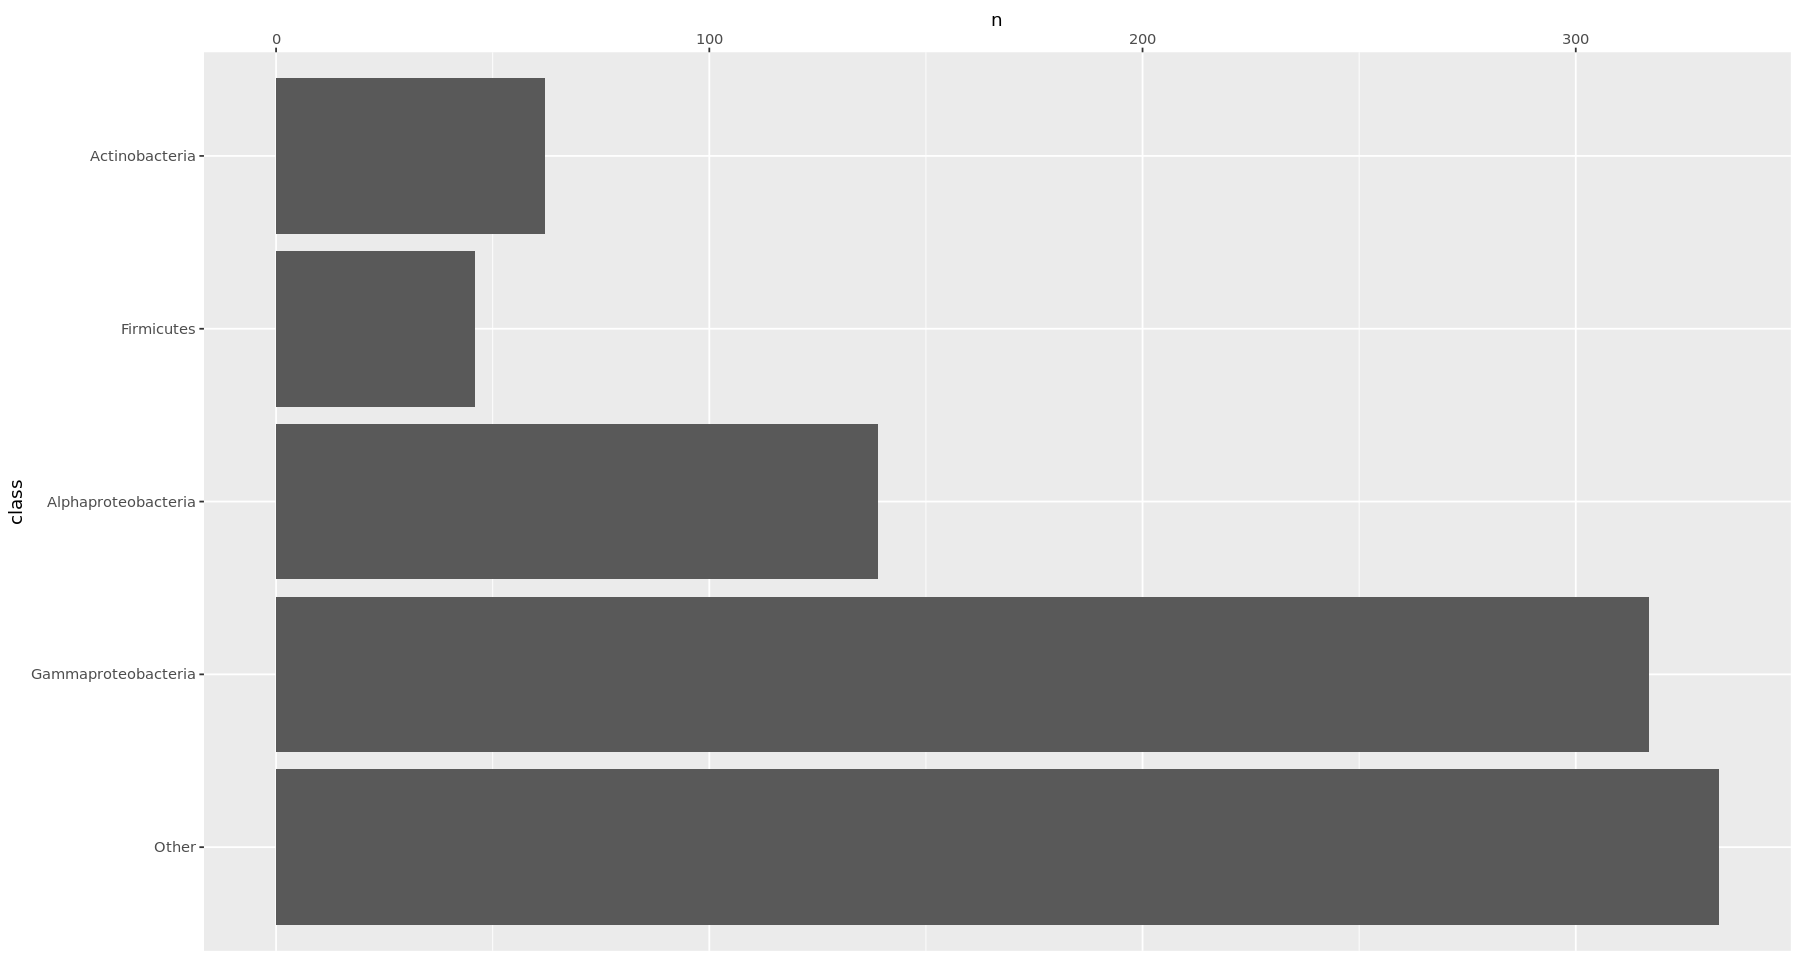

In [18]:
# totals
bars<-data.frame(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
group_by(class) %>%
summarise(n=n()) %>%
mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
ggplot(aes(x = class, y = n))+geom_col()+coord_flip()+scale_y_continuous(position="right")

#cairo_pdf(file = "allclass.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(bars,nrow =1, align="v", axis = "l")
#dev.off()

In [19]:
# totals with transporter
bars <- all[,grep("TRANSPORT", colnames(all))] %>%
mutate(total = rowSums(.)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                     class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
mutate(pa = ifelse(total > 0, 1, 0)) %>%
filter(pa == 1) %>%
select(class,pa) %>%
group_by(class) %>%
summarise(n=n()) %>%
mutate(class = factor(class, levels = c("Other", "Gammaproteobacteria", "Alphaproteobacteria", "Firmicutes", "Actinobacteria"))) %>%
ggplot(aes(x = class, y = n))+geom_col()+coord_flip()+scale_y_continuous(position="right")+theme_minimal()

cairo_pdf(file = "alltransportN.pdf", onefile = TRUE, width = 8.5, height = 11)
plot_grid(bars,nrow =1, align="v", axis = "l")
dev.off()

png 
  2

In [20]:
all <- pa
colnames(all) <- paste0(fn[2,],".",fn[1,])

a <- all %>%
mutate(transonly = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 0 & `SYNTHESIS.Glycine betaine` == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 1 & `SYNTHESIS.Glycine betaine` == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 0 & `SYNTHESIS.Glycine betaine` == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(`TRANSPORT.Glycine betaine` == 1 & `BREAKDOWN.Glycine betaine` == 1 & `SYNTHESIS.Glycine betaine` == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) #%>%
colnames(a)[2:5] <- paste0("gcb.",colnames(a)[2:5])

b <- all %>%
mutate(transonly = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 0 & SYNTHESIS.Sorbitol == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 1 & SYNTHESIS.Sorbitol == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 0 & SYNTHESIS.Sorbitol == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Sorbitol == 1 & BREAKDOWN.Sorbitol == 1 & SYNTHESIS.Sorbitol == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) #%>%
colnames(b)[2:5] <- paste0("sorbitol.",colnames(b)[2:5])

c <- all %>%
mutate(transonly = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 0 & SYNTHESIS.Mannitol == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 1 & SYNTHESIS.Mannitol == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 0 & SYNTHESIS.Mannitol == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Mannitol == 1 & BREAKDOWN.Mannitol == 1 & SYNTHESIS.Mannitol == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) #%>%
colnames(c)[2:5] <- paste0("mannitol.",colnames(c)[2:5])

d <- all %>%
mutate(transonly = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 0 & SYNTHESIS.Glycerol == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 1 & SYNTHESIS.Glycerol == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 0 & SYNTHESIS.Glycerol == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Glycerol == 1 & BREAKDOWN.Glycerol == 1 & SYNTHESIS.Glycerol == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) #%>%
colnames(d)[2:5] <- paste0("glyc.",colnames(d)[2:5])

e <- all %>%
mutate(transonly = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 0 & SYNTHESIS.Taurine == 0, 1, 0)) %>% # transporter only
mutate(transbreakd = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 1 & SYNTHESIS.Taurine == 0, 1, 0)) %>% # transporter + synthesis only
mutate(transsyn = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 0 & SYNTHESIS.Taurine == 1, 1, 0)) %>% # transporter + breakdown only
mutate(all = ifelse(TRANSPORT.Taurine == 1 & BREAKDOWN.Taurine == 1 & SYNTHESIS.Taurine == 1, 1, 0)) %>%
mutate(class = marref$custom) %>%
mutate(class = ifelse(class == "Actinobacteria" | class == "Alphaproteobacteria" | 
                      class == "Firmicutes" | class == "Gammaproteobacteria", class, "Other")) %>%
select(class, transonly, transbreakd, transsyn, all) %>%
group_by(class) %>%
summarise(transonly = sum(transonly), transbreakd = sum(transbreakd), transsyn = sum(transsyn), all = sum(all)) #%>%
colnames(e)[2:5] <- paste0("taur.",colnames(e)[2:5])

In [21]:
tmp <- merge(merge(merge(merge(a,b, by = "class"),c,by="class"),d,by="class"),e,by="class")
write.csv(tmp, file = "transportsum.csv")

In [22]:
# Checking which MMETSP have transporters
df <- read.table(
        file = "~/2020-osmolytes/genome-searching/predict_synthesis/2021-03-predicted-mmetsp-osmolyte-synthesis.tsv", 
                 sep = '\t', header = F)
dim(df)
# only keep metabs that have transporters
osmo <- c('Glycerol','Glycine betaine','Sorbitol','Mannitol','Taurine')
df <- df[, c(1,which(df[1,] %in% osmo))]
# make rownames MMETSP name
rownames(df)[3:654] <- df[3:654,1]
# keep only transport columns
df <- df[,which(df[2,] == "TRANSPORT")]
# remove the first two rows
colnames(df) <- df[1,]
df <- df[-c(1:2),]

#colsums
colSums(apply(df, 2, function(x) as.numeric(x)))

[1] 654  49

Glycerol Glycine betaine        Mannitol        Sorbitol         Taurine 
             10               1               0               0               1